# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image
from IPython.display import display
import seaborn as sns

# Dataset (CSV and images)

- The dataset consists of 512 CT scans of dimensions 512 x 512 pixels of the brain afflicted with cancer, tumour and aneurysm with 256 scans in jpg and 256 scans in dcm image formats. Examples are shown below

aneurysm scan
image dimensions (512, 512)


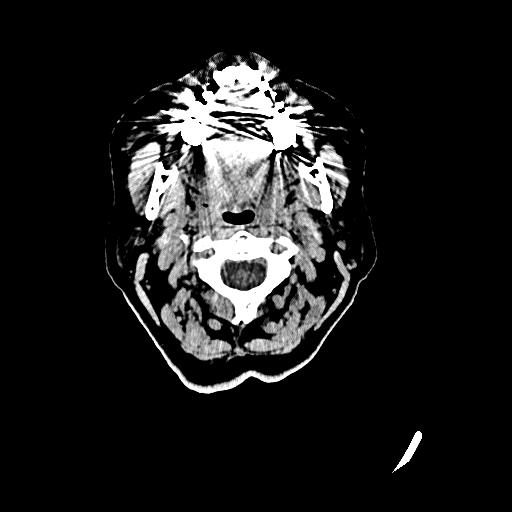

In [48]:
img = Image.open('') # add your own path to an aneurysm image
print('aneurysm scan')
print('image dimensions', img.size)
display(img)

cancer scan
image dimensions (512, 512)


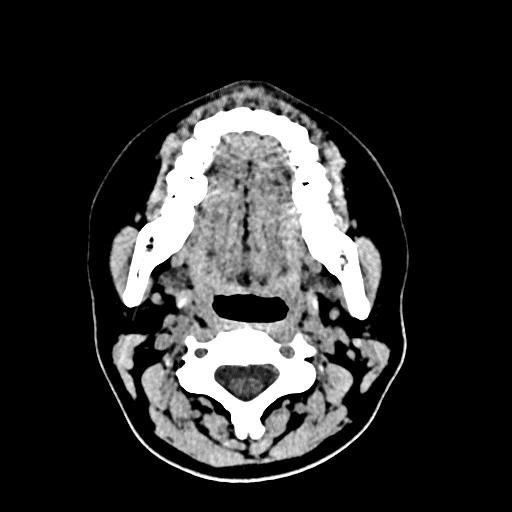

In [49]:
img = Image.open('') # add your own path to a cancer image
print('cancer scan')
print('image dimensions', img.size)
display(img)

tumor scan
image dimensions (512, 512)


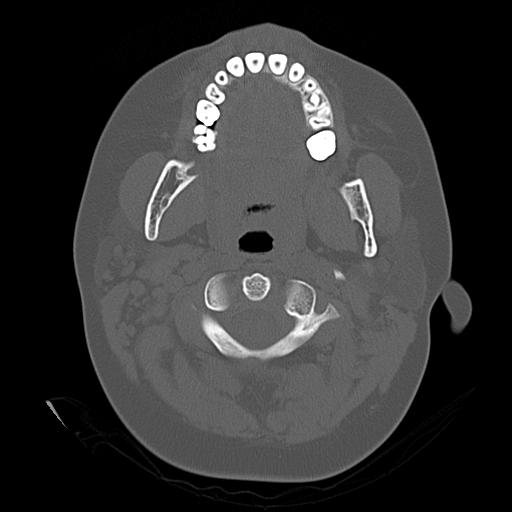

In [50]:
img = Image.open('') # add your own path to a tumor image
print('tumor scan')
print('image dimensions', img.size)
display(img)

- A CSV file, maps the image names of the respective image types to the class (cancer, tumour and aneurysm). The naming convention implies that the same scan is represented in jpg and dcm formats. For example, the scan with name ending ‘/aneurysm/0.jpg’ and its corresponding scan with name ending ‘/aneurysm/0.dcm’ represent the same scan just saved in different image formats. This can be seen in the below dataframe

In [51]:
df = pd.read_csv('ct_brain.csv')
df.head(5)

,dcm,jpg,type
0,/aneurysm/0.dcm,/aneurysm/0.jpg,aneurysm
1,/aneurysm/1.dcm,/aneurysm/1.jpg,aneurysm
2,/aneurysm/2.dcm,/aneurysm/2.jpg,aneurysm
3,/aneurysm/3.dcm,/aneurysm/3.jpg,aneurysm
4,/aneurysm/4.dcm,/aneurysm/4.jpg,aneurysm


# Exploratory Data Analysis

<AxesSubplot: xlabel='type', ylabel='count'>

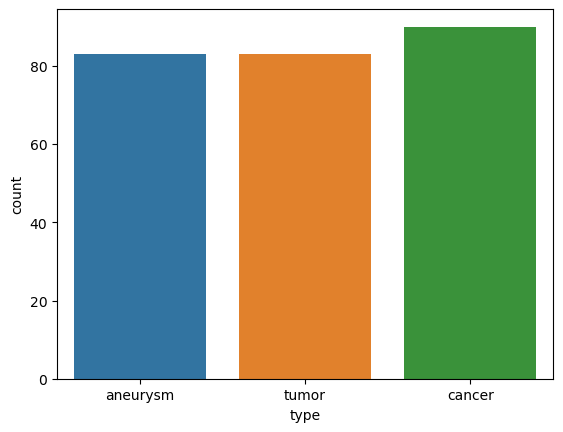

In [52]:
sns.countplot(x=df['type'])

In [53]:
print(df['type'].value_counts()) # Computes the count of unique values

cancer      90
aneurysm    83
tumor       83
Name: type, dtype: int64


- Both the aneurysm and tumour class have the same number of instances at 83 whereas the cancer class has slightly more at 90 instances. As the number of instances for each class are not significantly different from each other, it can be assumed that there is no class imbalance problem with the dataset.

# Data Pre-Processing

In [54]:
# Defines the base file path to the 'files' folder which contains the aneurysm, cancer and tumor folders in which scans for 
# the respective conditions are stored
base_path = ''

In [55]:
# Defines the empty list 'image_paths' to which paths to all images will be appended to
image_paths = []

# The ending of jpg file names as given by the column df['jpg'] is concatenated with the base_path and this gets appended to
# the image_paths list in a for loop. The end result is image_paths now contains a list of all paths of the jpg images
for i in df['jpg']:
    image_paths.append(base_path+i)

In [56]:
# The length of the image_paths list is 256. As there are 256 jpg images, the fact that there are 256 items in the 
# image_paths list shows that all paths to the jpg images have been successfully captured
len(image_paths)

256

In [58]:
# Creates the empty list 'images' to which arrays of each image will be appended to
images = []

for i in image_paths:
    # for each path within the image path list, the image is loaded
    image = load_img(i)
    
    # The image is then coverted to a Numpy array to make it compatible with Deep Learning models
    image = img_to_array(image)
    
    # The values in the array are normalised so that they range from 0 to 1
    image = image/255
    
    # appends the normalised array of the image to the list images
    images.append(image)
    

In [59]:
# Converts the list 'images' into a Numpy array
X = np.array(images)

In [60]:
# Creates the empty list 'category' to which the labels (aneurysm, cancer, tumor) will be appended to
category = []

# Appends all labels found in the df['type'] column to the category list in a for loop
for i in df['type']:
    category.append(i)

In [61]:
# applying LabelEncoder().fit_transform() to the 'category' variable which contains all labels returns encoded labels. This
# is assigned to the vaiable y, which is essentially the target
y = LabelEncoder().fit_transform(category)

# converts y into a Numpy array
y = np.array(y)

# The array 'y' which has encoded class values is converted into a binary class matrix
y = to_categorical(y)

# Model Development

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## CNN v2

In [82]:
# Define the model.
model_cnn = tf.keras.Sequential([
  # This is a Convolutional layer with 32 kernels of size 3x3. It is responsible for extracting features from the input image
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
  
  # once features are extracted, they need to be condensed into a smaller dimension of input data
  # Max pooling layer with a pool size of 2x2. The pooling layer's job is to condense information from the previous layer and
  # pass it on to the next layer. It reduces the dimensionality by downsampling it. The pool size is (2,2) which means it
  # will reduce the size of the input image by half. e.g. if input image is 50x50 then the size of image will be 25x25
  # we're using maxpooling2d as we are working with 2d images. 
  tf.keras.layers.MaxPooling2D((2, 2)),
    
  # Another convolutional layer 
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

  # Another Pooling layer
  tf.keras.layers.MaxPooling2D((2, 2)),
    
  
  # The input data is flattened
  # flatten layer which flattens the output of the pooling layer from 3d to 1d tensor.
  tf.keras.layers.Flatten(),
    
    
  # Add a dropout layer with a dropout rate of 20%.
  tf.keras.layers.Dropout(0.2), # 0.2 signifies that we are selecting 20% of nodes in 
                                # dropout layer to be switched off randomly during feed forward propagation
  
  # The flattened input data is then passed to the hidden layers of neural network in the CNN.
  # Dense layer with 128 units and a relu activation function.
  tf.keras.layers.Dense(128, activation='relu'),
    
  # Another dropout layer
  tf.keras.layers.Dropout(0.2),
  
  # Dense layer with 3 units and a softmax activation function.
  tf.keras.layers.Dense(3, activation='softmax')
])

In [152]:
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 255, 255, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 126, 126, 64)      0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 1016064)           0         
                                                                 
 dropout_14 (Dropout)        (None, 1016064)          

In [83]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # epochs to wait for improvement
    min_delta=0.01,  # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restores model weights from the epoch with best weights
)


In [86]:
# fitting our model 
history_cnn = model_cnn.fit(X_train, y_train, validation_split=0.1, epochs=20, callbacks=[early_stopping])

Epoch 1/20
6/6 [==============================] - 28s 4s/step - loss: 1.3477 - accuracy: 0.5792 - val_loss: 0.8831 - val_accuracy: 0.8095
Epoch 2/20
6/6 [==============================] - 22s 4s/step - loss: 0.3211 - accuracy: 0.8798 - val_loss: 0.3394 - val_accuracy: 0.9048
Epoch 3/20
6/6 [==============================] - 21s 3s/step - loss: 0.1874 - accuracy: 0.9563 - val_loss: 0.2057 - val_accuracy: 0.9524
Epoch 4/20
6/6 [==============================] - 21s 4s/step - loss: 0.1696 - accuracy: 0.9563 - val_loss: 0.1383 - val_accuracy: 0.9524
Epoch 5/20
6/6 [==============================] - 21s 4s/step - loss: 0.1045 - accuracy: 0.9836 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 21s 3s/step - loss: 0.0655 - accuracy: 0.9891 - val_loss: 0.2357 - val_accuracy: 0.9524
Epoch 7/20
6/6 [==============================] - 21s 3s/step - loss: 0.0839 - accuracy: 0.9891 - val_loss: 0.3259 - val_accuracy: 0.9524
Epoch 8/20
6/6 [==================

In [87]:
model_cnn.evaluate(X_test, y_test)

2/2 [==============================] - 1s 432ms/step - loss: 0.0340 - accuracy: 1.0000


[0.03403276577591896, 1.0]

In [160]:
tr_acc_cnn = history_cnn.history['accuracy'][0:5]
val_acc_cnn = history_cnn.history['val_accuracy'][0:5]

tr_loss_cnn = history_cnn.history['loss'][0:5]
val_loss_cnn = history_cnn.history['val_loss'][0:5]

In [161]:
epoch_num = [i for i in range(1, len(tr_acc_cnn)+1)]

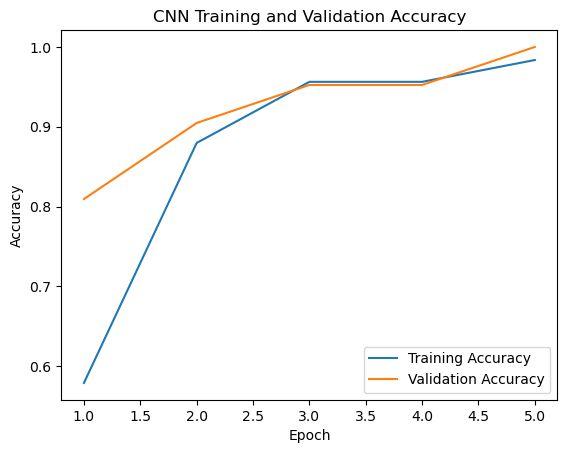

In [162]:
plt.plot(epoch_num, tr_acc_cnn, label='Training Accuracy') 
plt.plot(epoch_num, val_acc_cnn, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

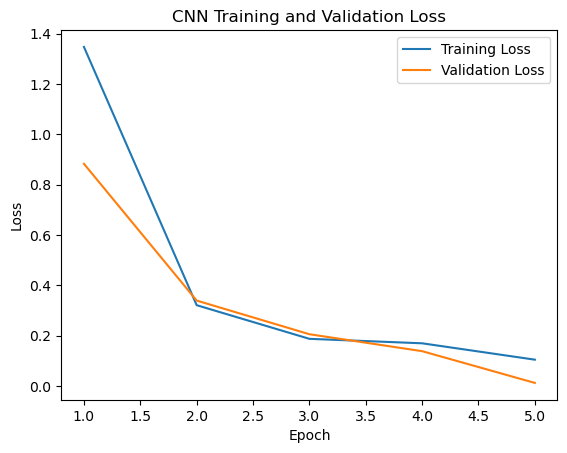

In [163]:
plt.plot(epoch_num, tr_loss_cnn, label='Training Loss') 
plt.plot(epoch_num, val_loss_cnn, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## MLP

In [143]:
# Create a sequential model. This is a slightly updated DL model with dropout layers
model_mlp = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(512, 512, 3)),

  # Add a dropout layer with a dropout rate of 20%.
  tf.keras.layers.Dropout(0.2),

  # Add a hidden layer with 128 neurons.
  tf.keras.layers.Dense(128, activation='relu'),

  # Add another dropout layer with a dropout rate of 20%.
  tf.keras.layers.Dropout(0.2),

  # Add a hidden layer with 64 neurons.
  tf.keras.layers.Dense(64, activation='relu'),

  # Add a final hidden layer with 10 neurons and a softmax activation for classification.
  tf.keras.layers.Dense(3, activation='softmax') 
])

In [153]:
model_mlp.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 786432)            0         
                                                                 
 dropout_24 (Dropout)        (None, 786432)            0         
                                                                 
 dense_28 (Dense)            (None, 128)               100663424 
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dense_30 (Dense)            (None, 3)                 195       
                                                                 
Total params: 100671875 (384.03 MB)
Trainable params:

In [144]:
model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [145]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # epochs to wait for improvement
    min_delta=0.01,  # Minimum change to qualify as an improvement
    restore_best_weights=True  # Restores model weights from the epoch with best weights
)


In [146]:
# Train the model.
history_mlp = model_mlp.fit(X_train, y_train, validation_split=0.1, epochs=20, callbacks=[early_stopping])

Epoch 1/20
6/6 [==============================] - 7s 1s/step - loss: 7.3869 - accuracy: 0.5355 - val_loss: 7.0732 - val_accuracy: 0.4762
Epoch 2/20
6/6 [==============================] - 5s 810ms/step - loss: 3.7742 - accuracy: 0.6831 - val_loss: 3.4353 - val_accuracy: 0.8095
Epoch 3/20
6/6 [==============================] - 5s 826ms/step - loss: 1.3693 - accuracy: 0.8197 - val_loss: 0.4757 - val_accuracy: 0.9048
Epoch 4/20
6/6 [==============================] - 5s 772ms/step - loss: 0.7584 - accuracy: 0.8743 - val_loss: 1.2870 - val_accuracy: 0.8095
Epoch 5/20
6/6 [==============================] - 5s 776ms/step - loss: 0.6053 - accuracy: 0.9126 - val_loss: 0.8675 - val_accuracy: 0.8571
Epoch 6/20
6/6 [==============================] - 5s 819ms/step - loss: 0.5641 - accuracy: 0.9235 - val_loss: 0.0835 - val_accuracy: 0.9524
Epoch 7/20
6/6 [==============================] - 5s 773ms/step - loss: 0.8632 - accuracy: 0.9399 - val_loss: 0.3147 - val_accuracy: 0.9524
Epoch 8/20
6/6 [=======

In [147]:
model_mlp.evaluate(X_test, y_test)

2/2 [==============================] - 0s 40ms/step - loss: 0.0371 - accuracy: 0.9615


[0.03712381795048714, 0.9615384340286255]

In [164]:
tr_acc_mlp = history_mlp.history['accuracy'][0:6]
val_acc_mlp = history_mlp.history['val_accuracy'][0:6]

tr_loss_mlp = history_mlp.history['loss'][0:6]
val_loss_mlp = history_mlp.history['val_loss'][0:6]

In [165]:
epoch_num = [i for i in range(1, len(tr_acc_mlp)+1)]

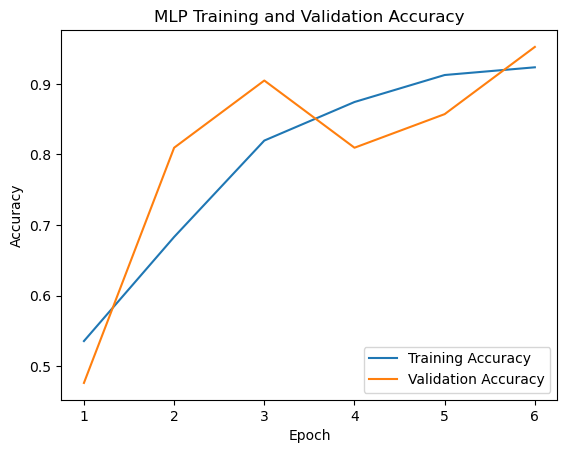

In [166]:
plt.plot(epoch_num, tr_acc_mlp, label='Training Accuracy') 
plt.plot(epoch_num, val_acc_mlp, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('MLP Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

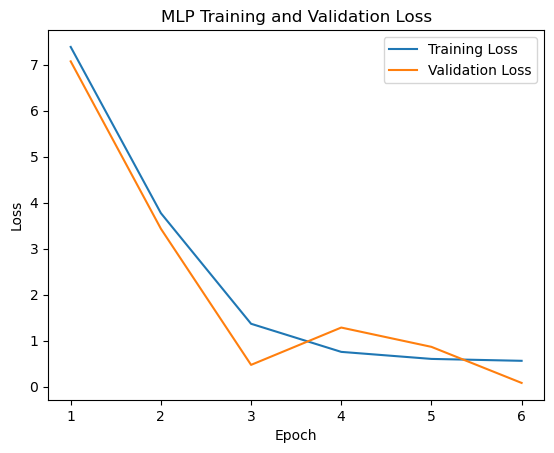

In [167]:
plt.plot(epoch_num, tr_loss_mlp, label='Training Loss') 
plt.plot(epoch_num, val_loss_mlp, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('MLP Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [172]:
df_cnn_results = pd.DataFrame({'tr_acc_cnn':tr_acc_cnn, 
                              'val_acc_cnn':val_acc_cnn, 
                              'tr_loss_cnn':tr_loss_cnn, 
                              'val_loss_cnn':val_loss_cnn})

In [173]:
print(df_cnn_results)

   tr_acc_cnn  val_acc_cnn  tr_loss_cnn  val_loss_cnn
0    0.579235     0.809524     1.347668      0.883050
1    0.879781     0.904762     0.321099      0.339395
2    0.956284     0.952381     0.187369      0.205666
3    0.956284     0.952381     0.169596      0.138298
4    0.983607     1.000000     0.104518      0.012107


In [170]:
df_mlp_results = pd.DataFrame({'tr_acc_mlp':tr_acc_mlp, 
                              'val_acc_mlp':val_acc_mlp, 
                              'tr_loss_mlp':tr_loss_mlp, 
                              'val_loss_mlp':val_loss_mlp})

In [171]:
print(df_mlp_results)

   tr_acc_mlp  val_acc_mlp  tr_loss_mlp  val_loss_mlp
0    0.535519     0.476190     7.386948      7.073228
1    0.683060     0.809524     3.774221      3.435254
2    0.819672     0.904762     1.369297      0.475709
3    0.874317     0.809524     0.758419      1.287013
4    0.912568     0.857143     0.605286      0.867493
5    0.923497     0.952381     0.564075      0.083507


- Both training and validation accuracies for CNN and MLP models increase rapidly during the early epochs showing that both models are learning quickly and generalising well to new data, although it is more rapid in the CNN than the MLP


- Both training and validation losses for CNN and MLP models shown a similar pattern where during early epochs, both losses for both models decrease rapidly although the loss reduction happens more quickly in CNN than MLP


- It can also be seen that the starting losses in the first epoch are many times lower than that of the MLP model. This makes sense as a CNN will represent an input image as a matrix allowing it to better capture features whereas an MLP disregards spatial information and requires an input image to be flattened. This would allow the CNN model to outperform the MLP model


- The results of evaluating each model on the test data show similar performance with CNN with a test accuracy and test loss of 1 and 0.0340 respectively and the MLP with 0.9615 and 0.0371 respectively


- The test accuracies and for both models are on par with those in literature 


- The CNN model however achieves 100% accuracy, which is an improvement on the studies from the literature review however such a result is extremely unlikely and may indicate overfitting


- It was hypothesised that a CNN model would perform better than a MLP model as CNN’s are tailored for image classification. While this was found in the results, there is not a very large disparity between CNN and MLP


- This gives weight to the earlier assumption that scans of each class represent the same person. This would mean both models are learning features relevant to each person and not the condition itself


- Without confirmation if each image represents a different person, no images for ‘normal’ CT scans and the small size of the dataset, it can be concluded that a deep learning model trained on this dataset should not be used for medical diagnostics